In [52]:
from scipy.io import mmread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the .mtx file
# file found under https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-2983/downloads
matrix = mmread('data/GSE294399_WBC_020823_matrix.mtx/matrix.mtx')

# The matrix is now a sparse matrix in COO format
#print(matrix)

# To convert to a dense array
dense_matrix = matrix.toarray()
df = pd.DataFrame(dense_matrix)
#df.to_csv("matrix.csv", index=False)

# Reconstruct Full Cell-Gene Matrix from Compressed Files
This code reconstructs the full cell-gene presence matrix (num_cells x num_genes) from the compressed files: `cell_gene_presence.csv` and `cluster_marker_genes.csv`. Each entry is 1 if the gene is present in the cell, 0 otherwise.

C:\Users\srjnk\AppData\Local\Temp\ipykernel_7832\4287705789.py:38: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  genes_in_cell = (cluster_genes - absent_genes) | present_genes


Compression accuracy: 99.06%


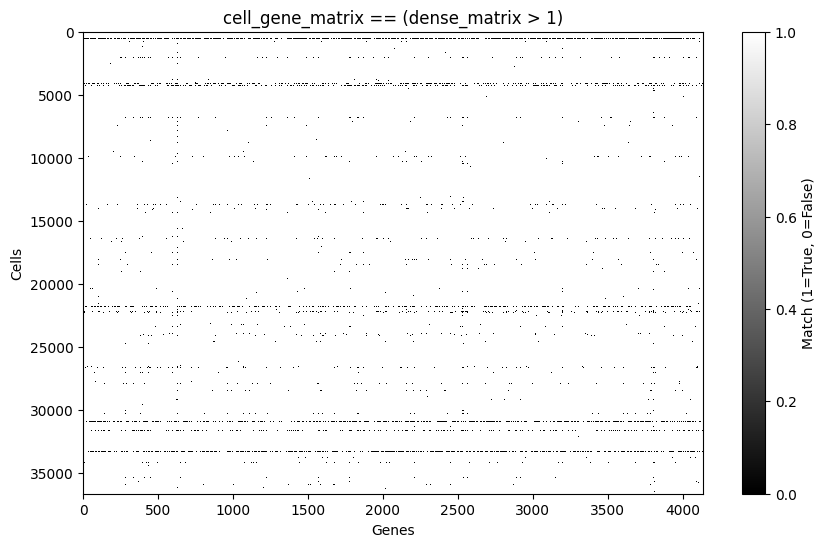

In [53]:
# Load cluster marker genes
cluster_marker_df = pd.read_csv('cluster_marker_genes.csv', header=None)
# Build a mapping: cluster_id -> set of marker gene indices
cluster_to_genes = {}
for idx, row in cluster_marker_df.iterrows():
    cluster_id = idx + 1  # assuming clusters are 1-indexed
    genes = set(map(int, row.dropna().values[1:]))
    cluster_to_genes[cluster_id] = genes

# Load cell gene presence
cell_gene_presence_df = pd.read_csv('cell_gene_presence.csv', header=None)
num_cells = cell_gene_presence_df.shape[0]
# Get all unique gene indices from all clusters for matrix size
all_genes = set()
for genes in cluster_to_genes.values():
    all_genes.update(genes)
num_genes = max(all_genes)

# Initialize the cell-gene matrix
cell_gene_matrix = np.zeros((num_genes, num_cells), dtype=np.uint8)

for i, row in cell_gene_presence_df.iterrows():
    cell_idx = int(row[0])
    cluster_id = int(row[1])
    # Genes in cluster
    cluster_genes = cluster_to_genes[cluster_id]
    # Genes in cell but not in cluster
    num_present_genes = int(row[2])
    
    present_genes_slice = slice(3, 3 + num_present_genes)
    present_genes = row[present_genes_slice]
    
    num_absent_genes = int(row[3 + num_present_genes])
    
    absent_genes_slice = slice(3 + num_present_genes, 3 + num_present_genes + num_absent_genes)
    absent_genes = row[absent_genes_slice]
    # Genes present in cell: (cluster genes - genes_in_cluster_not_cell) | genes_in_cell_not_cluster
    genes_in_cell = (cluster_genes - absent_genes) | present_genes
    for gene_idx in genes_in_cell:
        cell_gene_matrix[gene_idx-1, cell_idx-1] = 1
    break
acc = 100 * (cell_gene_matrix == (dense_matrix > 1).astype(np.uint8)).sum(axis=None) / (num_genes * num_cells)
print(f"Compression accuracy: {np.round(acc, 2)}%")

# Visualize the difference between reconstructed and original matrix
# Ensure both matrices are the same shape
if cell_gene_matrix.shape == dense_matrix.shape:
    diff = (cell_gene_matrix == (dense_matrix > 1).astype(np.uint8))
    plt.figure(figsize=(10, 6))
    plt.imshow(diff, aspect='auto', interpolation='nearest', cmap='gray')
    plt.title('cell_gene_matrix == (dense_matrix > 1)')
    plt.xlabel('Genes')
    plt.ylabel('Cells')
    plt.colorbar(label='Match (1=True, 0=False)')
    plt.show()
else:
    print(f"Shape mismatch: cell_gene_matrix {cell_gene_matrix.shape}, dense_matrix {dense_matrix.shape}")